In [17]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
blocks = gpd.read_file("../data/blocks/tl_2022_23_tabblock20_with_nodes.shp.zip")

In [3]:
blocks.dtypes

STATEFP20       object
COUNTYFP20      object
TRACTCE20       object
BLOCKCE20       object
GEOID20         object
NAME20          object
MTFCC20         object
UR20           float64
UACE20         float64
UATYPE20       float64
FUNCSTAT20      object
ALAND20          int64
AWATER20         int64
INTPTLAT20      object
INTPTLON20      object
HOUSING20        int64
POP20            int64
osmid            int64
geometry      geometry
dtype: object

In [4]:
conserved_lands = gpd.read_file("../data/conserved_lands/Maine_Conserved_Lands_with_nodes.shp.zip")

In [5]:
df = pd.read_csv("../data/walk_times/walk_times_block_df.csv", index_col=0)
df.columns

Index(['tract_osmid', 'land_osmid', 'trip_time'], dtype='object')

In [6]:
df_with_lands = df.merge(conserved_lands.drop(columns='geometry'), how="left", left_on="land_osmid", right_on="osmid")
df_with_lands.head(1)

,tract_osmid,land_osmid,trip_time,OBJECTID,PROJECT,PARCEL_NAM,DESIGNATIO,CONS1_TYPE,HOLD1_NAME,HOLD1_TYPE,...,IFW_ID,LMF_ID,DEPT_ID,NOTE_,GAP_STATUS,IUCN_STATU,CL_UNIQUEI,TAX_MAP_TO,TAX_MAP_BO,osmid
0,8685714496,101941807,15,28,Colonial Pemaquid,NaN,State Historic Site,Fee,Maine Bureau of Parks and Lands,State,...,NaN,NaN,NaN,5/5/1956 Photo w Property Lines; CAP,4-Unsecured (temporary easements lands and/or ...,NaN,5912,NaN,NaN,101941807


In [7]:
merge = gpd.GeoDataFrame(blocks.merge(df_with_lands, how="outer", left_on="osmid", right_on="tract_osmid"))
merge.columns

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20',
       'NAME20', 'MTFCC20', 'UR20', 'UACE20', 'UATYPE20', 'FUNCSTAT20',
       'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'HOUSING20', 'POP20',
       'osmid_x', 'geometry', 'tract_osmid', 'land_osmid', 'trip_time',
       'OBJECTID', 'PROJECT', 'PARCEL_NAM', 'DESIGNATIO', 'CONS1_TYPE',
       'HOLD1_NAME', 'HOLD1_TYPE', 'CONS2_TYPE', 'HOLD2_NAME', 'HOLD2_TYPE',
       'ECO_RESERV', 'ACQ_YEAR', 'ACQ_DATE', 'RPT_AC', 'CALC_AC', 'PUB_ACCESS',
       'PURPOSE1', 'PURPOSE2', 'BPL_ID', 'IFW_ID', 'LMF_ID', 'DEPT_ID',
       'NOTE_', 'GAP_STATUS', 'IUCN_STATU', 'CL_UNIQUEI', 'TAX_MAP_TO',
       'TAX_MAP_BO', 'osmid_y'],
      dtype='object')

In [8]:
trip_times = merge["trip_time"].dropna().unique().astype(int)
trip_times.sort()

In [9]:
for time in trip_times:
    # copy acres column
    merge["AC_"+str(time)] = merge["CALC_AC"]
    # delete values for non-matching times
    merge["AC_"+str(time)][np.logical_not(merge["trip_time"] == time)] = pd.NA

/tmp/ipykernel_8535/1919367070.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge["AC_"+str(time)][np.logical_not(merge["trip_time"] == time)] = pd.NA
/tmp/ipykernel_8535/1919367070.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge["AC_"+str(time)][np.logical_not(merge["trip_time"] == time)] = pd.NA
/tmp/ipykernel_8535/1919367070.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge["AC_"+str(time)][np.logical_not(me

In [10]:
trip_cols = ["AC_"+str(time) for time in trip_times]

In [11]:
ac_sums = pd.concat([merge.dropna(subset=col).groupby("BLOCKCE20")[col].sum() for col in trip_cols], axis=1)

<AxesSubplot: xlabel='value', ylabel='Count'>

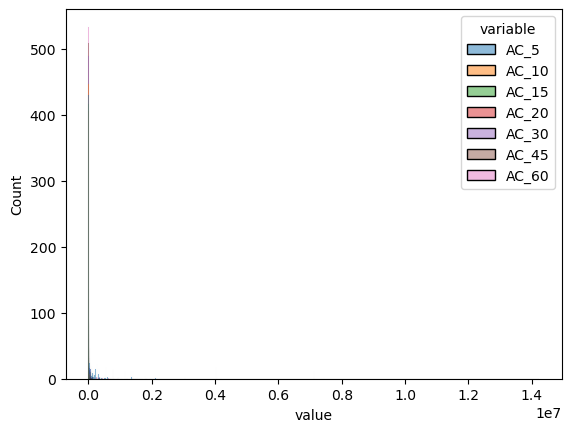

In [12]:
sns.histplot(ac_sums.melt(), x="value", hue="variable")

In [13]:
dissolve = merge.dissolve("BLOCKCE20", "sum")

/home/philip/miniconda3/envs/ox/lib/python3.11/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


Text(0.5, 1.0, 'Acres of Conserved Land within 10 Minute Walk of Block Center')

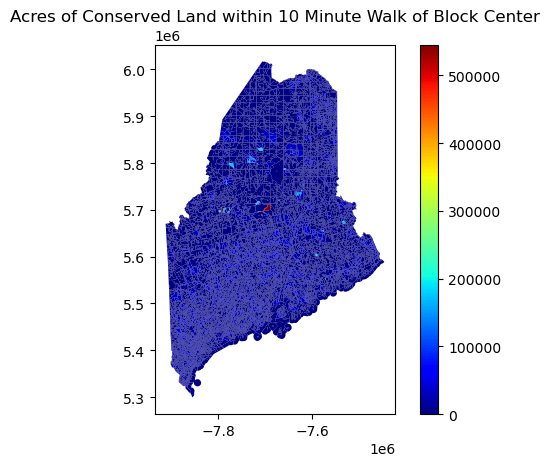

In [14]:
ax = dissolve.plot("AC_10", cmap="jet", legend=True)
ax.set_title("Acres of Conserved Land within 10 Minute Walk of Block Center")

In [15]:
dissolve.to_file("../data/joins/block_dissolve.shp.zip")

/tmp/ipykernel_8535/1154593663.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dissolve.to_file("../data/joins/block_dissolve.shp.zip")


In [33]:
desc = dissolve[dissolve["AC_10"] > 0]["AC_10"].describe()
desc

count       732.000000
mean      24471.631100
std       87841.164003
min           0.009931
25%         127.826135
50%        1186.090178
75%       13531.548194
max      545697.878008
Name: AC_10, dtype: float64

Text(0.5, 1.0, 'Acres of Conserved Land within 10 Minute Walk of Block Center')

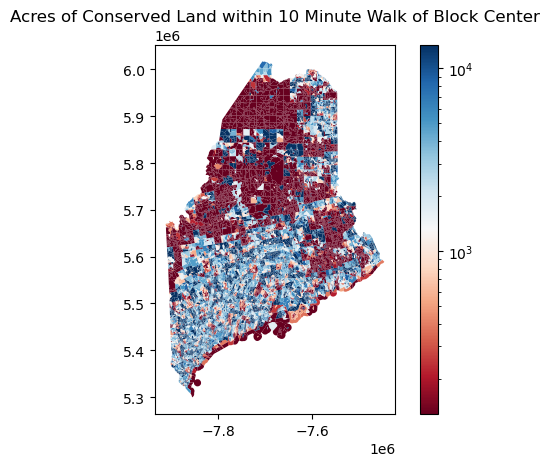

In [39]:
ax = dissolve.plot("AC_10", cmap="RdBu", legend=True, norm=LogNorm(desc["25%"], desc["75%"], clip=True))
ax.set_title("Acres of Conserved Land within 10 Minute Walk of Block Center")